# 通过文本相似度评价近义词挖掘
近义词经常有相同的文字，例如“明月”和“山月”，“春”和“春风”。虽然不是所有近义词都有相同的文字，因此直接使用文本相似度来挖掘近义词是不合适的，但是文本相似度对一组近义词关系的好坏有一定的表达能力，可以评价近义词挖掘算法的好坏。如果挖掘出的近义词彼此文本相似度高，认为结果是好的。

这里，把两个词的文本相似度定义为，在两个词都出现的字的个数 * 200 / 两个词的长度之和。

一个词评分为，它和它的近义词的文本相似度求和，再除以近义词数。

挖掘结果的评分为每个词的评分求和。

In [1]:
import numpy as np
import pickle
import pandas as pd
with open('./var/word2id', 'rb') as f:
    word2id = pickle.load(f)
with open('./var/id2word', 'rb') as f:
    id2word = pickle.load(f)
with open('./var/TF', 'rb') as f:
    TF = pickle.load(f)
with open('./var/IDF', 'rb') as f:
    IDF = pickle.load(f)
new_data = pd.read_excel('./var/new_data.xlsx')
with open('./var/big2id', 'rb') as f:
    big2id = pickle.load(f)
with open('./var/id2big', 'rb') as f:
    id2big = pickle.load(f)
big_num = len(id2big)

In [15]:
def evaluate_synonym(pathname, syn_num):
    '''
    评价挖掘结果
    '''
    with open(pathname, 'rb') as f:
        synonym_list = pickle.load(f)
    # 加载文件
    score = 0
    for idx, synonyms in enumerate(synonym_list):
        synonyms = synonyms[:syn_num]
        word = id2word[idx]
        cur_score = 0
        for syn_id in synonyms:
            syn = id2word[syn_id]
            cnt = 0
            for c in word:
                if c in syn:
                    cnt += 1
            cur_score += (cnt * 200) / (len(word) + len(syn))
        score += cur_score / len(synonyms)
    return score

evaluate_synonym('./var/synonym_list', 3)

2571.111111111109

## 1. 研究在同首诗和同句的相对权重对近义词表现的影响
同句的额外权重从 0 到 22 分别尝试，没有找到什么规律。

In [3]:
def synonym_digging(pathname, factor):
    '''
    近义词挖掘
    '''
    word_num = len(word2id)
        
    context = np.zeros((big_num, word_num))

    def cnt_context(poem):
        for place, row in poem.iterrows():
            word = row['word']
            line_num = row['line_number']
            id = word2id[word]
            if id in id2big:
                bigid = id2big[id]
                for con_place, con_row in poem.iterrows():
                    con_word = con_row['word']
                    con_id = word2id[con_word]
                    con_line_num = con_row['line_number']
                    if id != con_id:
                        context[bigid][con_id] += IDF[con_id]
                        if line_num == con_line_num:
                            context[bigid][con_id] += IDF[con_id] * factor
    
    new_data.groupby('Poem_id').apply(cnt_context)

    for line in context:
        line /= np.linalg.norm(line)

    from sklearn.decomposition import PCA
    dec_to = 32
    dcontext = PCA(n_components = dec_to).fit_transform(context)
        
    synonym_list = []
    for i in range(big_num):
        cur_list = []
        moon_vec = dcontext[i]
        similarity = np.zeros(big_num)
        for i, v in enumerate(dcontext):
            similarity[i] = np.linalg.norm(moon_vec - v)

        st = np.argsort(similarity)
        for i in range(1,30):
            cur_list.append(st[i])
        synonym_list.append(cur_list)
        
    with open(pathname, 'wb') as f:
        pickle.dump(synonym_list, f)

In [4]:
factor_list = []
for factor in range(0, 20, 2):
    print(factor)
    pathname = './result/result_' + str(factor)
    synonym_digging(pathname, factor)
    factor_list.append(factor)

0
2
4
6
8
10
12
14
16
18


In [28]:
for factor in range(20, 24, 2):
    print(factor)
    pathname = './result/result_' + str(factor)
    synonym_digging(pathname, factor)
    factor_list.append(factor)

20
22


In [69]:
score = []
for factor in range(0, 24, 2):
    print(factor)
    pathname = './result/result_' + str(factor)
    score.append(evaluate_synonym(pathname, 10))

0
2
4
6
8
10
12
14
16
18
20
22


In [70]:
factor_list

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]

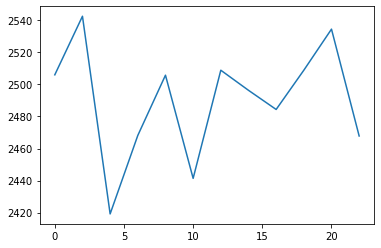

In [71]:
import matplotlib.pyplot as plt
plt.plot(factor_list, score)

In [50]:
score

[2505.9770114942303,
 2542.5287356321646,
 2419.1954022988325,
 2468.1609195402107,
 2505.747126436761,
 2441.379310344809,
 2508.8505747126214,
 2496.3218390804423,
 2484.3678160919326,
 2508.850574712621,
 2534.4827586206693,
 2467.816091954003]

In [84]:
# Test
with open('./var/synonym_list', 'rb') as f:
    synonym_list = pickle.load(f)
for i in synonym_list[id2big[word2id['']]]:
    print(id2word[big2id[i]])

水精
斜月
千门


## 2.研究降至多少维效果最好
尝试了 4 维到 2048 维，结果如曲线，128 维左右效果最好

In [85]:
def synonym_digging_pca(pathname, factor):
    '''
    近义词挖掘
    '''
    word_num = len(word2id)
        
    context = np.zeros((big_num, word_num))

    def cnt_context(poem):
        for place, row in poem.iterrows():
            word = row['word']
            line_num = row['line_number']
            id = word2id[word]
            if id in id2big:
                bigid = id2big[id]
                for con_place, con_row in poem.iterrows():
                    con_word = con_row['word']
                    con_id = word2id[con_word]
                    con_line_num = con_row['line_number']
                    if id != con_id:
                        context[bigid][con_id] += IDF[con_id]
                        if line_num == con_line_num:
                            context[bigid][con_id] += IDF[con_id] * 10
    
    new_data.groupby('Poem_id').apply(cnt_context)

    for line in context:
        line /= np.linalg.norm(line)

    from sklearn.decomposition import PCA
    dec_to = factor
    dcontext = PCA(n_components = dec_to).fit_transform(context)
        
    synonym_list = []
    for i in range(big_num):
        cur_list = []
        moon_vec = dcontext[i]
        similarity = np.zeros(big_num)
        for i, v in enumerate(dcontext):
            similarity[i] = np.linalg.norm(moon_vec - v)

        st = np.argsort(similarity)
        for i in range(1,30):
            cur_list.append(st[i])
        synonym_list.append(cur_list)
        
    with open(pathname, 'wb') as f:
        pickle.dump(synonym_list, f)

In [86]:
pca_factor_list = []
pca_factor = 2
for i in range(10):
    print(pca_factor)
    pca_factor *= 2
    pathname = './result/pca_' + str(pca_factor)
    synonym_digging_pca(pathname, pca_factor)
    pca_factor_list.append(pca_factor)

2
4
8
16
32
64
128
256
512
1024


In [99]:
pca_score = []
pca_factor = 2
for i in range(10):
    print(pca_factor)
    pca_factor *= 2
    pathname = './result/pca_' + str(pca_factor)
    pca_score.append(evaluate_synonym(pathname, 10))

2
4
8
16
32
64
128
256
512
1024


Text(0, 0.5, 'score')

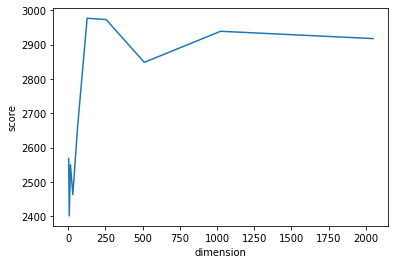

In [105]:
plt.plot(pca_factor_list, pca_score)
plt.xlabel('dimension')
plt.ylabel('score')

In [103]:
pca_score

[2568.3333333333335,
 2400.6666666666665,
 2550.0000000000005,
 2463.0,
 2660.666666666667,
 2977.333333333332,
 2973.333333333331,
 2848.666666666665,
 2939.333333333331,
 2917.9999999999977]

In [104]:
pca_factor_list

[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]